<a href="https://colab.research.google.com/github/kimdesok/DeepPATH/blob/master/Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
import sys
from sklearn import preprocessing
print(tf.__version__)

import random

!python --version

2.8.2
Python 3.7.13


In [8]:
!cp -r  ./drive/MyDrive/datasets/TFRecord_Train .

In [9]:
!cp -r ./drive/MyDrive/models/LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5 .

In [39]:
tf.keras.backend.clear_session()

#Set your parameters here

BATCH_SIZE = 300
BUFFER_SIZE = 2000
DROP_OUT = 0.7
REGULARIZER = 'l1'

SET_TYPE = 'small set' #full, ensemble, new, retrain

NO_EPOCHS = 200
PATIENCE = 15

LEARN_RATE = 0.01
LEARN_RATE1 = 0.0001

DECAY_RATE = 0.96
DECAY_STEPS = 10000

MODEL_NAME_FINAL = 'LUAD-Normal_model_full_Adam_0.01_80_0.7.h5'

MODEL_NAME_FINER = 'LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5'

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [299, 299]

def decayed_learning_rate(step, initial_learning_rate=LEARN_RATE, decay_rate=DECAY_RATE, decay_steps=DECAY_STEPS):
    operand = step/float(decay_steps)
    return initial_learning_rate * decay_rate**(operand)

scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, offset=-1)

In [40]:
from functools import partial
import sys

def decode_image(image):
    
    image = tf.image.decode_jpeg(image,  channels=3)
    image = tf.cast(image, tf.float32)
    assert len(image.shape) == 3
    assert image.shape[2] == 3
    image = tf.reshape(image, [*IMAGE_SIZE, 3])    
    return image

"""
Dataset is loaded for the model to find features and patterns. 
The labels in the dataset provides the groundtruth information. 
"""
# To extract the image and the label data from each TFRecord
'''
The original TFRecord consists of the following data
          'image/height': tf.io.FixedLenFeature([], tf.int64),
          'image/width': tf.io.FixedLenFeature([], tf.int64),
          'image/colorspace': tf.io.FixedLenFeature([], tf.string),
          'image/channels': tf.io.FixedLenFeature([], tf.int64),
          'image/class/label': tf.io.FixedLenFeature([], tf.int64),
          'image/class/text': tf.io.VarLenFeature([], tf.string),
          'image/format': tf.io.FixedLenFeature([], tf.string),
          'image/filename': tf.io.VarLenFeature([], tf.string),
'''
def read_tfrecord(example, labeled=True):
  
    #To create a dictionary describing the features. 
    tfrecord_format = (
        {
              'image/encoded': tf.io.FixedLenFeature([], tf.string),
              'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        } 
        if labeled
        else {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
        }
    )
    
    #Define a parser
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    #Convert the data
    image = decode_image(example["image/encoded"])
    
    
    if labeled:
        label = tf.cast(example["image/class/label"], tf.int32) #No need to cast to tf.int32. why?
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    
    read_in_multi = partial(read_tfrecord, labeled=labeled)
    
    dataset = dataset.map(
        read_in_multi, num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset


#Get the dataset with JPEG images and labels together, shuffle, prefetch, and batch
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE) # 64 is better for the unbalanced dataset
    return dataset

def plot_histogram(values, filename):
    plt.figure(figsize=(16, 8))
    plt.rc('font', size=14) 
    plt.hist(values, bins=20)  # density=False would make counts
    plt.title("Model prediction distribution")
    plt.ylabel('Frequency')
    plt.xlabel('Prediction Values')

     # save plot to file

    plt.savefig(filename + '_plot.png')
    #plt.close()

In [41]:
data_path ='./TFRecord_Train'
tfrecord_filenames = os.listdir(data_path)
test_data_filenames = [os.path.join(data_path, name) for name in tfrecord_filenames if 'test' in name]

# Shuffle the data filenames to remove the ordering

random.shuffle(test_data_filenames)

if(SET_TYPE == 'small set'):
    test_data_filenames = test_data_filenames[:1]
    test_dataset = get_dataset(test_data_filenames)
    no_of_datafiles = int(len(test_data_filenames))

else:
    test_dataset = get_dataset(test_data_filenames)
    no_of_datafiles = int(len(test_data_filenames))
    
print('test_dataset is loaded with %d TFRecords.'%no_of_datafiles)
#print(type(test_dataset))

test_dataset is loaded with 1 TFRecords.


In [42]:
print('Loading the final model: %s'%MODEL_NAME_FINER)
model = tf.keras.models.load_model(MODEL_NAME_FINER)

initial_learning_rate = LEARN_RATE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=tf.keras.metrics.AUC(name="auc") #For the imbalanced data, AUC is the preferred metric.
)

Loading the final model: LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5


In [62]:
#TFRecod files to image generator so it can be input to the predict()
ALL_IMAGES_PROCESSING = True

def get_prediction(image_batch):
    
    print(type(image_batch))

    class_index = list()
    
    idx = 0
    for x in image_batch:
        
        #print('x shape:', np.array(x).shape)
        x_scaled = tf.keras.preprocessing.image.img_to_array(x)
        x_scaled = scale_layer(x_scaled)
        x_scaled = tf.expand_dims(x_scaled, axis=0)
        #print('x shape:', np.array(x).shape)
        images = np.vstack([x_scaled])
        #print('images shape:', np.array(images).shape)
        
        value = model.predict(images)[0]
        
        class_index.append(value)

        if(idx%10 == 0):
          print()
        print(idx, value, end=' ')
        idx += 1
      
    return class_index

def save_test_data(test_data_filenames, test_dataset, predict_list, threshold = 0.5):
  isdir = os.path.isdir('/content/Tumor_Images/')
  print(isdir)
  dir_path = '/content/Tumor_Images/'
  if isdir == False:
    os.mkdir(dir_path)

  print(type(test_data_filenames), len(test_data_filenames))
  
  name = 0
  for idx, x in enumerate(test_dataset):
    if(predict_list[idx] > threshold):
      dest_path = os.path.join(dir_path, str(name)+'.JPEG')
      tf.keras.utils.save_img(dest_path, x, scale=False)
      name += 1

In [44]:
#Things to do:
#1) label and filename parsed -> how to deal with the raw image only?
#2) The use of one shot iterator helps?
# reference: https://stackoverflow.com/questions/55438316/the-image-and-the-label-do-not-correspond-in-tfrecord

if(ALL_IMAGES_PROCESSING):
    test_dataset = load_dataset(test_data_filenames, labeled=False)
else:
    test_dataset = get_dataset(test_data_filenames)

#a MirroredStrategy object. This will handle distribution and provide a context manager 
# (MirroredStrategy.scope) to build your model inside.  
# https://www.tensorflow.org/tutorials/distribute/keras

strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    predict_list = get_prediction(test_dataset)
    print('Length %d'%len(predict_list))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>

0 [0.9965413] 1 [0.99638593] 2 [0.9964935] 3 [0.9963509] 4 [0.99654996] 5 [0.9967424] 6 [0.99670154] 7 [0.9961648] 8 [0.99608] 9 [0.99637336] 
10 [0.9962501] 11 [0.99628323] 12 [0.99670106] 13 [0.99654835] 14 [0.99654263] 15 [0.99640864] 16 [0.9965849] 17 [0.99677294] 18 [0.9962968] 19 [0.99650395] 
20 [0.99684024] 21 [0.99679035] 22 [0.99621177] 23 [0.9965161] 24 [0.99618775] 25 [0.99661773] 26 [0.996338] 27 [0.99609715] 28 [0.9961527] 29 [0.9966086] 
30 [0.99554247] 31 [0.99636996] 32 [0.99651897] 33 [0.9963116] 34 [0.9967344] 35 [0.99704796] 36 [0.99683017] 37 [0.9966415] 38 [0.99636924] 39 [0.99658644] 
40 [0.99687093] 41 [0.99708825] 42 [0.99695045] 43 [0.99670994] 44 [0.9966433] 45 [0.99650145] 46


True
<class 'list'> 1
(46,)


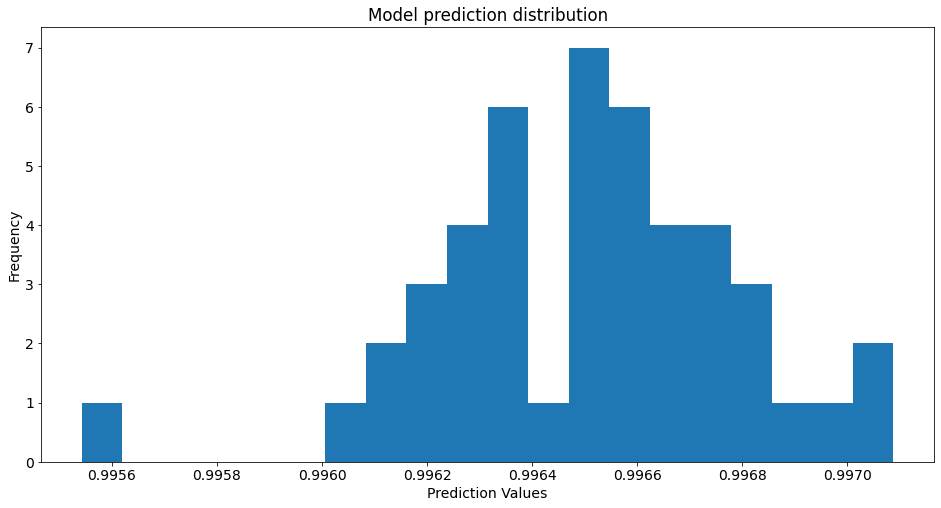

In [63]:
save_test_data(test_data_filenames, test_dataset, predict_list)

print(np.array(predict_list).flatten().shape)
plot_histogram(np.array(predict_list).flatten() , 'old_finetune')

## Classified JPEG images need to be saved in a separare folders for the further processing
> We'll use our model to predict results for our test dataset images. 

> Values closer to `0` are more likely to be benign and values closer to `1` are more likely to be malignant.